In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tempfile

In [2]:
train_file = "./train.csv"
test_file = "./test.csv"
num_cols = ["ps_reg_01", "ps_reg_02", "ps_reg_03","ps_car_12", "ps_car_13", "ps_car_14", "ps_car_15"]
ignore_cols = ["id", "target", "ps_calc_01", "ps_calc_02", "ps_calc_03", "ps_calc_04", "ps_calc_05", 
               "ps_calc_06", "ps_calc_07", "ps_calc_08", "ps_calc_09", "ps_calc_10", "ps_calc_11", 
               "ps_calc_12", "ps_calc_13", "ps_calc_14","ps_calc_15_bin", "ps_calc_16_bin", 
               "ps_calc_17_bin","ps_calc_18_bin", "ps_calc_19_bin", "ps_calc_20_bin"]

In [3]:
cfg = {
    "feature_size": None,
    "field_size": None,
    "embed_size": 128,
    "deep_nn":[256,256],
    "dropout_fm": 0,
    "dropout_deep": 0.2,
    "output_bias": None,
    "epoch": 200,
    "batch":10000,
    "split": 0.2
}

In [4]:
def overview(cfg):    
    dfTrain = pd.read_csv(train_file)
    dfTest = pd.read_csv(test_file)
    df = pd.concat([dfTrain,dfTest], sort=False)

    field_size = len(df.columns) - len(ignore_cols)
    feature_dict = {}
    feature_size = 0
    for col in df.columns:
        if col in ignore_cols:
            continue
        elif col in num_cols:
            feature_dict[col] = feature_size
            feature_size += 1
        else:
            unique_val = df[col].unique()
            feature_dict[col] = dict(zip(unique_val,range(feature_size,len(unique_val) + feature_size)))
            feature_size += len(unique_val)
    
    cfg['field_size'] = field_size
    cfg['feature_size'] = feature_size
    return dfTrain, feature_dict

In [5]:
dfTrain, feature_dict = overview(cfg)

In [6]:
def preprocess(train_df, feature_dict, cfg):
    label_df = train_df[['target']]  
    neg, pos = np.bincount(label_df.values.flatten())
    cfg['output_bias'] = np.log([pos/neg])
    train_df.drop(['target','id'],axis=1,inplace=True)
    feature_idx = train_df.copy()
    feature_val = train_df.copy()
    for col in feature_idx.columns:
        if col in ignore_cols:
            feature_idx.drop(col,axis=1,inplace=True)
            feature_val.drop(col,axis=1,inplace=True)
            continue
        elif col in num_cols:
            feature_idx[col] = feature_dict[col]
        else:
            feature_idx[col] = feature_idx[col].map(feature_dict[col])
            feature_val[col] = 1      
            
    train_idx_df, test_idx_df = train_test_split(feature_idx, test_size=cfg["split"])
    train_val_df, test_val_df = train_test_split(feature_val, test_size=cfg["split"])
    train_label_df, test_label_df = train_test_split(label_df, test_size=cfg["split"])
    
    train_idx_df, validate_idx_df = train_test_split(train_idx_df, test_size=cfg["split"])
    train_val_df, validate_val_df = train_test_split(train_val_df, test_size=cfg["split"])
    train_label_df, validate_label_df = train_test_split(train_label_df, test_size=cfg["split"])
    
    train_input = [train_idx_df.values, train_val_df.values]
    train_label = np.array(train_label_df['target'])
    bool_train_labels = train_label != 0
    
    validate_input = [validate_idx_df.values, validate_val_df.values]
    validate_label = validate_label_df.values
    
    test_input = [test_idx_df.values, test_val_df.values]
    test_label = test_label_df.values
    
    return train_input, train_label, bool_train_labels, validate_input, validate_label, test_input, test_label

In [7]:
train_input, train_label, bool_train_labels, validate_input, validate_label, test_input, test_label = preprocess(dfTrain, feature_dict, cfg)

In [8]:
def oversample(train_input, train_label, bool_train_labels):
    pos_idx = train_input[0][bool_train_labels]
    neg_idx = train_input[0][~bool_train_labels]
    pos_val = train_input[1][bool_train_labels]
    neg_val = train_input[1][~bool_train_labels]
    pos_label = train_label[bool_train_labels]
    neg_label = train_label[~bool_train_labels]
    
    ids = np.arange(len(pos_idx))
    choices = np.random.choice(ids, len(neg_idx))
    
    res_pos_idx = pos_idx[choices]
    res_pos_val = pos_val[choices]
    res_pos_label = pos_label[choices]
    
    resampled_idx = np.concatenate([res_pos_idx, neg_idx], axis=0)
    resampled_val = np.concatenate([res_pos_val, neg_val], axis=0)
    resampled_label = np.concatenate([res_pos_label, neg_label], axis=0)

    order = np.arange(len(resampled_label))
    np.random.shuffle(order)    
    return [resampled_idx[order], resampled_val[order]], resampled_label[order]

In [9]:
res_train_input, res_train_label = oversample(train_input, train_label, bool_train_labels)

In [10]:
class DeepFM(tf.keras.Model):
    def __init__(self, cfg):
        super(DeepFM, self).__init__()
        self.feature_size = cfg['feature_size']
        self.field_size = cfg['field_size']
        self.embed_size = cfg['embed_size']
        self.deep_nn = cfg['deep_nn']
        
        self.dropout_fm = cfg['dropout_fm']
        self.dropout_deep = cfg['dropout_deep']
        
        # fm        
        self.feature_weight = tf.keras.layers.Embedding(cfg['feature_size'], 1)
        self.feature_embed = tf.keras.layers.Embedding(cfg['feature_size'], cfg['embed_size'])

        # dnn
        for layer in range(len(cfg['deep_nn'])):
            setattr(self, 'dense_' + str(layer), tf.keras.layers.Dense(self.deep_nn[layer]))
            setattr(self, 'batchNorm_' + str(layer), tf.keras.layers.BatchNormalization())
            setattr(self, 'activation_' + str(layer), tf.keras.layers.Activation('relu'))
            setattr(self, 'dropout_' + str(layer), tf.keras.layers.Dropout(self.dropout_deep))
            
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', 
                                        bias_initializer=tf.keras.initializers.Constant(cfg['output_bias']))

    def call(self, inputs, training=True):
        # inputs = [feature_idx, feature_val]
        reshaped_feature_val = tf.cast(tf.reshape(inputs[1], shape=[-1,self.field_size,1]), tf.float32)
        # linear        
        weights = self.feature_weight(inputs[0])
        linear = tf.reduce_sum(tf.multiply(weights,reshaped_feature_val),2)
        
        # fm  
        embeddings = self.feature_embed(inputs[0])
        second_inner = tf.multiply(embeddings,reshaped_feature_val)
        
        summed_features_emb = tf.reduce_sum(second_inner,1)
        summed_features_emb_square = tf.square(summed_features_emb)
        
        squared_features_emb = tf.square(second_inner)
        squared_sum_features_emb = tf.reduce_sum(squared_features_emb,1)
        
        fm = 0.5 * tf.subtract(summed_features_emb_square,squared_sum_features_emb)
        
        # dnn
        y_deep = tf.reshape(embeddings,shape=[-1,self.field_size * self.embed_size])
        for layer in range(0, len(self.deep_nn)):
            y_deep = getattr(self, 'dense_' + str(layer))(y_deep)
            y_deep = getattr(self, 'batchNorm_' + str(layer))(y_deep, training=training)
            y_deep = getattr(self, 'activation_' + str(layer))(y_deep)
            y_deep = getattr(self, 'dropout_' + str(layer))(y_deep, training=training)
            
        # concat
        concat = tf.concat([linear, fm, y_deep], axis=1)                                
        out = self.fc(concat)
        return out

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max',restore_best_weights=True)
metrics = [tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'), 
           tf.keras.metrics.BinaryAccuracy(name='bin_acc'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [31]:
model = DeepFM(cfg)
model.load_weights('init_params/weights')
# model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=metrics)
model.fit(res_train_input, res_train_label, epochs=cfg['epoch'], batch_size=cfg['batch'], shuffle=True, 
          verbose=1, callbacks = [early_stopping], validation_data=(validate_input, validate_label))

Train on 733992 samples, validate on 95234 samples
Epoch 1/200
733992/733992 [==============================] - 16s 21us/sample - loss: 0.6925 - tp: 16488.0000 - fp: 10261.0000 - tn: 356735.0000 - fn: 350508.0000 - bin_acc: 0.5085 - precision: 0.6164 - recall: 0.0449 - auc: 0.5154 - val_loss: 0.8447 - val_tp: 890.0000 - val_fp: 24140.0000 - val_tn: 67650.0000 - val_fn: 2554.0000 - val_bin_acc: 0.7197 - val_precision: 0.0356 - val_recall: 0.2584 - val_auc: 0.4950
Epoch 2/200
733992/733992 [==============================] - 13s 17us/sample - loss: 0.6837 - tp: 32683.0000 - fp: 9346.0000 - tn: 357650.0000 - fn: 334313.0000 - bin_acc: 0.5318 - precision: 0.7776 - recall: 0.0891 - auc: 0.5385 - val_loss: 0.7592 - val_tp: 360.0000 - val_fp: 9898.0000 - val_tn: 81892.0000 - val_fn: 3084.0000 - val_bin_acc: 0.8637 - val_precision: 0.0351 - val_recall: 0.1045 - val_auc: 0.4986
Epoch 3/200
733992/733992 [==============================] - 13s 17us/sample - loss: 0.6764 - tp: 54118.0000 - fp: 1367

In [16]:
test_predict = model.predict(test_input, batch_size=cfg['batch'])

In [20]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.7108537666722112
tp :  116.0
fp :  3282.0
tn :  111450.0
fn :  4195.0
bin_acc :  0.9371908
precision :  0.03413773
recall :  0.02690791
auc :  0.49842232

Legitimate Transactions Detected (True Negatives):  111450
Legitimate Transactions Incorrectly Detected (False Positives):  3282
Fraudulent Transactions Missed (False Negatives):  4195
Fraudulent Transactions Detected (True Positives):  116
Total Fraudulent Transactions:  4311


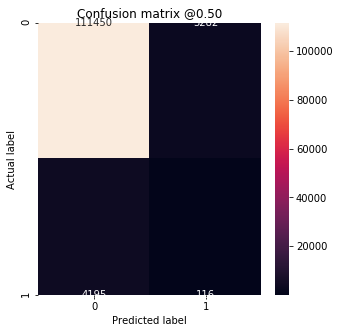

In [21]:
test_results = model.evaluate(test_input, test_label, batch_size=cfg['batch'], verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(name, ': ', value)
print()

plot_cm(test_label, test_predict)

In [17]:
check_pd = pd.concat([pd.DataFrame(test_predict), pd.DataFrame(test_label)], axis=1)
check_pd.columns = ['predict', 'true']
sort = check_pd.sort_values(by=["true","predict"],ascending=False)
sort[:182]

,predict,true
14896,1.000000,1
45540,1.000000,1
52188,1.000000,1
7873,0.999997,1
15672,0.999988,1
...,...,...
91740,0.160829,1
104640,0.159829,1
56736,0.159499,1
4643,0.157478,1


In [33]:
tf.keras.models.save_model(model, 'try.tf', overwrite=True, include_optimizer=True)

INFO:tensorflow:Assets written to: try.tf/assets


In [37]:
model.summary()

Model: "deep_fm_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  257       
_________________________________________________________________
embedding_7 (Embedding)      multiple                  32896     
_________________________________________________________________
dense_9 (Dense)              multiple                  1212672   
_________________________________________________________________
batch_normalization_6 (Batch multiple                  1024      
_________________________________________________________________
activation_6 (Activation)    multiple                  0         
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  65

In [38]:
del model

In [39]:
demo_model = tf.keras.models.load_model('try.tf', compile=False)

In [41]:
test_predict = demo_model.predict(test_input, batch_size=cfg['batch'])

AttributeError: 'DeepFM' object has no attribute 'loss'